In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
sys.path.append('/tf/crypto_prediction_ml_dl/script')
from trino_operations import trino_operator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.losses import mean_squared_error
from sklearn import metrics

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# run eagerly should be set to true. 
tf.config.run_functions_eagerly(True)

import copy


warnings.filterwarnings("ignore")
trino_ope = trino_operator.Operator()



def create_dataframe_from_query(query,column_list):
    res = trino_ope.run_query(query)

    indicators_query_result = {}
    for idx, row_data in enumerate(res,1):
        indicators_query_result[int(idx)] = row_data

    indicators_raw_df = pd.DataFrame.from_dict(
        indicators_query_result, orient="index", columns=column_list
    )

    return indicators_raw_df


def wmae_loss(y_true, y_pred):
    
    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    l = 1.5
    
    diff = y_true[:,0] - y_pred[:,0]
    
    w_true = step_function(y_true[:, 1])
    w_pred = step_function(calculate_gain(y_pred[:, 1]))
    
    # Weighted mean absolute error
    threshold = w_true * diff
    wae = step_function(threshold) * ((l + abs(w_true - w_pred)) * abs(diff)) \
            + (1 - step_function(threshold)) * ((1/l) * abs(diff))
    wmae = sum(wae) / wae.shape[0]
    
    return wmae

def wmse_loss(y_true, y_pred):
    
    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    l = 1.5

    # -1.0 <= absolute_diff <= 1.0
    absolute_diff = y_true[:,0] - y_pred[:,0]
    
    # 1.0 <= squared_diff
    squared_diff = step_function(absolute_diff) * (absolute_diff+2)**2 \
            + (1 - step_function(absolute_diff)) * (absolute_diff-2)**2
    
    w_true = step_function(y_true[:, 1])
    w_pred = step_function(calculate_gain(y_pred[:, 1]))
    
    # Weighted mean squared erhiror
    threshold = w_true * absolute_diff
    wse = step_function(threshold) * ((l + abs(w_true - w_pred)) * abs(squared_diff)) \
            + (1 - step_function(threshold)) * ((1/l) * abs(squared_diff))
    wmse = sum(wse) / wse.shape[0]
    
    return wmse


def f1_metric(true, pred):

    def step_function(data):
        return np.where(data >= 0, 1, 0)
    
    def calculate_gain(data):
        # Set the first gain value is 1 since there is no past data for the first data.
        gain_data = np.append(np.ndarray([1]), (data[1:] / data[:-1]) - 1.0)
        return gain_data
    
    g_true = step_function(true[:, 1])
    g_pred = step_function(calculate_gain(pred[:, 0]))

    ground_positives = K.cast(K.sum(g_true, axis=0), "float") + K.epsilon()       # = TP + FN
    pred_positives = K.cast(K.sum(g_pred, axis=0), "float") + K.epsilon()         # = TP + FP
    true_positives = K.cast(K.sum(g_true * g_pred, axis=0), "float") + K.epsilon()  # = TP
    
    precision = true_positives / pred_positives 
    recall = true_positives / ground_positives
        #both = 1 if ground_positives == 0 or pred_positives == 0
        #shape (4,)

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
        #still with shape (4,)

    return f1

2023-11-11 04:48:03.560109: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-11 04:48:03.586235: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


2023-11-11 04:48:04.455675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 04:48:04.459507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-11 04:48:04.459628: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [11]:
########################
# Create BTC_USDT featrue dataframe
########################
query = f"""
    with 
    ohlcv_minute_data as
    (
        select 
            open,
            high,
            low,
            close,
            amount as total_volume,
            quantity as total_quantity,
            tradeCount as total_trade_count,
            date_trunc('minute',ts_create_utc) as ts
        from 
            hive.crypto_raw.candles_minute 
        where 
            id = 'BTC_USDT'
    ),
    buy_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as buy_trade_count,
            sum(amount) as sum_buy_taker_amount,
            sum(quantity)  as sum_buy_taker_quantity,
            avg(price) as avg_buy_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'buy'
        group by
            1
    ), 
    sell_tacker_market_data as
    (
        select
            date_trunc('minute',ts_create_utc) as ts,
            count(trade_id) as sell_trade_count,
            sum(amount) as sum_sell_taker_amount,
            sum(quantity) as sum_sell_taker_quantity,
            avg(price) as avg_sell_trade_price
        from 
            hive.crypto_raw.market_trade
        where
            id = 'BTC_USDT'
            and takerSide = 'sell'
        group by
            1
    )
    select
        a.open as open,
        a.high as high,
        a.low as low,
        a.close as close,
        a.total_volume as total_volume,
        a.total_quantity as total_quantity,
        a.total_trade_count as total_trade_count,
        b.buy_trade_count as buy_trade_count,
        b.sum_buy_taker_amount as sum_buy_taker_amount,
        b.sum_buy_taker_quantity as sum_buy_taker_quantity,
        b.avg_buy_trade_price as avg_buy_trade_price,
        c.sell_trade_count as sell_trade_count,
        c.sum_sell_taker_amount as sum_sell_taker_amount,
        c.sum_sell_taker_quantity as sum_sell_taker_quantity,
        c.avg_sell_trade_price as avg_sell_trade_price,
        a.ts as ts
    from
        ohlcv_minute_data as a
    left join
        buy_tacker_market_data as b
    on a.ts = b.ts
    left join
        sell_tacker_market_data as c
    on 
        a.ts = c.ts
    where 
        b.buy_trade_count is not null
        and c.sell_trade_count is not null
    order by
        a.ts
"""

column_list = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price',
    'ts'
]
btc_raw_df = create_dataframe_from_query(query,column_list)
btc_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts
93551,36609.49,36620.24,36601.02,36619.90,107610.70,2.939085,75,35,47552.1800,1.298780,36613.605,40,60058.527000,1.640305,36614.13,2023-11-10 10:37:00
93552,36619.14,36628.87,36611.66,36621.26,110156.95,3.007775,79,38,59794.5900,1.632677,36623.758,41,50362.360000,1.375098,36623.91,2023-11-10 10:38:00
93553,36621.26,36630.66,36609.78,36620.83,102758.72,2.805888,74,37,48875.0620,1.334560,36622.960,37,53883.664000,1.471328,36622.10,2023-11-10 10:39:00
93554,36619.25,36630.66,36619.17,36621.18,20554.95,0.561305,14,4,5730.0205,0.156475,36622.203,10,14824.932000,0.404830,36620.09,2023-11-10 10:40:00
93555,36608.68,36608.68,36538.55,36538.55,1601.73,0.043827,11,9,1595.0424,0.043644,36546.074,2,6.696044,0.000183,36579.34,2023-11-10 10:46:00


In [12]:
p1_close_price = btc_raw_df["close"].shift(1)
btc_raw_df["p1_gain"] = btc_raw_df["close"] / p1_close_price - 1.0

p3_close_price = btc_raw_df["close"].shift(3)
btc_raw_df["p3_gain"] = btc_raw_df["close"] / p3_close_price - 1.0

btc_raw_df

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain,p3_gain
1,25824.44,25831.18,25819.53,25825.24,95769.52,3.708438,72,41,53700.4500,2.079428,25825.186,31,42069.074000,1.629010,25824.785,2023-09-02 12:11:00,NaN,NaN
2,25825.69,25831.18,25824.56,25825.60,84266.64,3.262884,61,24,28694.2970,1.111076,25825.957,37,55572.350000,2.151808,25825.865,2023-09-02 12:12:00,0.000014,NaN
3,25825.46,25826.37,25820.69,25825.53,75424.89,2.920544,56,29,36727.9600,1.422152,25825.590,27,38696.934000,1.498392,25825.506,2023-09-02 12:13:00,-0.000003,NaN
4,25825.41,25830.08,25824.86,25826.63,64327.65,2.490819,51,24,27203.9940,1.053362,25826.016,27,37123.660000,1.437457,25825.879,2023-09-02 12:14:00,0.000043,0.000054
5,25826.25,25831.17,25825.55,25826.26,66004.63,2.555701,44,24,33439.0300,1.294760,25826.838,20,32565.605000,1.260941,25826.398,2023-09-02 12:15:00,-0.000014,0.000026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93551,36609.49,36620.24,36601.02,36619.90,107610.70,2.939085,75,35,47552.1800,1.298780,36613.605,40,60058.527000,1.640305,36614.130,2023-11-10 10:37:00,0.000295,0.000718
93552,36619.14,36628.87,36611.66,36621.26,110156.95,3.007775,79,38,59794.5900,1.632677,36623.758,41,50362.360000,1.375098,36623.910,2023-11-10 10:38:00,0.000037,0.000729
93553,36621.26,36630.66,36609.78,36620.83,102758.72,2.805888,74,37,48875.0620,1.334560,36622.960,37,53883.664000,1.471328,36622.100,2023-11-10 10:39:00,-0.000012,0.000321
93554,36619.25,36630.66,36619.17,36621.18,20554.95,0.561305,14,4,5730.0205,0.156475,36622.203,10,14824.932000,0.404830,36620.090,2023-11-10 10:40:00,0.000010,0.000035


In [13]:
####################################
# Create Dataset with target value
####################################
predicting_points = 3
btc_df_with_target = btc_raw_df
target_column_to_predict = 'close'
future_close = btc_raw_df[target_column_to_predict].shift(-predicting_points)
btc_df_with_target['future_close'] = future_close
btc_df_with_target.tail(10)

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain,p3_gain,future_close
93546,36588.81,36605.80,36576.90,36598.59,127524.66,3.484980,89,43,56838.5600,1.553277,36593.113,46,70686.100000,1.931703,36592.43,2023-11-10 10:32:00,0.000231,0.000668,36594.60
93547,36598.73,36598.73,36573.96,36589.25,132391.88,3.618292,89,56,79392.4100,2.169785,36590.285,33,52999.473000,1.448507,36588.59,2023-11-10 10:33:00,-0.000255,0.000579,36609.09
93548,36588.61,36601.15,36585.07,36593.62,127558.52,3.486159,90,51,63323.5080,1.730605,36591.470,39,64235.016000,1.755554,36589.83,2023-11-10 10:34:00,0.000119,0.000095,36619.90
93549,36593.80,36598.49,36580.47,36594.60,126004.02,3.443281,96,46,62533.4900,1.708794,36594.375,50,63470.540000,1.734487,36593.68,2023-11-10 10:35:00,0.000027,-0.000109,36621.26
93550,36593.54,36609.13,36588.61,36609.09,132787.66,3.627791,94,42,55941.6130,1.528340,36602.254,52,76846.055000,2.099451,36602.63,2023-11-10 10:36:00,0.000396,0.000542,36620.83
93551,36609.49,36620.24,36601.02,36619.90,107610.70,2.939085,75,35,47552.1800,1.298780,36613.605,40,60058.527000,1.640305,36614.13,2023-11-10 10:37:00,0.000295,0.000718,36621.18
93552,36619.14,36628.87,36611.66,36621.26,110156.95,3.007775,79,38,59794.5900,1.632677,36623.758,41,50362.360000,1.375098,36623.91,2023-11-10 10:38:00,0.000037,0.000729,36538.55
93553,36621.26,36630.66,36609.78,36620.83,102758.72,2.805888,74,37,48875.0620,1.334560,36622.960,37,53883.664000,1.471328,36622.10,2023-11-10 10:39:00,-0.000012,0.000321,NaN
93554,36619.25,36630.66,36619.17,36621.18,20554.95,0.561305,14,4,5730.0205,0.156475,36622.203,10,14824.932000,0.404830,36620.09,2023-11-10 10:40:00,0.000010,0.000035,NaN
93555,36608.68,36608.68,36538.55,36538.55,1601.73,0.043827,11,9,1595.0424,0.043644,36546.074,2,6.696044,0.000183,36579.34,2023-11-10 10:46:00,-0.002256,-0.002259,NaN


In [15]:
# Check if the target value is defined as the future close value.
btc_df_with_target[['close','future_close','p1_gain','p3_gain']].tail(10)

,close,future_close,p1_gain,p3_gain
93546,36598.59,36594.60,0.000231,0.000668
93547,36589.25,36609.09,-0.000255,0.000579
93548,36593.62,36619.90,0.000119,0.000095
93549,36594.60,36621.26,0.000027,-0.000109
93550,36609.09,36620.83,0.000396,0.000542
93551,36619.90,36621.18,0.000295,0.000718
93552,36621.26,36538.55,0.000037,0.000729
93553,36620.83,NaN,-0.000012,0.000321
93554,36621.18,NaN,0.000010,0.000035
93555,36538.55,NaN,-0.002256,-0.002259


In [17]:
# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 93555
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
p1_gain: 1
p3_gain: 3
future_close: 3


In [18]:
btc_df_with_target = btc_df_with_target.dropna()

# NaN value might be included in the dataset.
# Count the number of NaN for each column.
labels = []
values = []
print('# of records:',btc_df_with_target.shape[0])
print('<column name>: # of NaN records in the column')
for col in btc_df_with_target.columns:
    labels.append(col)
    values.append(btc_df_with_target[col].isnull().sum())
    print("{}: {}".format(col, values[-1]))

# of records: 93549
<column name>: # of NaN records in the column
open: 0
high: 0
low: 0
close: 0
total_volume: 0
total_quantity: 0
total_trade_count: 0
buy_trade_count: 0
sum_buy_taker_amount: 0
sum_buy_taker_quantity: 0
avg_buy_trade_price: 0
sell_trade_count: 0
sum_sell_taker_amount: 0
sum_sell_taker_quantity: 0
avg_sell_trade_price: 0
ts: 0
p1_gain: 0
p3_gain: 0
future_close: 0


In [19]:
btc_df_with_target.describe()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,ts,p1_gain,p3_gain,future_close
count,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549.000000,93549,9.354900e+04,93549.000000,93549.000000
mean,29022.111279,29029.579759,29014.827579,29022.647382,33944.765106,1.151353,29.385862,14.550107,17123.578619,0.580154,29022.882826,14.832943,16818.627970,0.571125,29021.967152,2023-10-07 04:34:39.317576960,3.871689e-06,0.000012,29022.992679
min,24947.390000,25004.330000,24923.650000,24947.410000,5.400000,0.000173,2.000000,1.000000,0.026938,0.000001,24962.285000,1.000000,0.027108,0.000001,24974.842000,2023-09-02 12:14:00,-1.500610e-02,-0.027941,24947.410000
25%,26542.610000,26547.530000,26539.230000,26542.930000,16241.100000,0.577953,15.000000,7.000000,7578.971000,0.268585,26543.467000,7.000000,7574.723600,0.268500,26542.848000,2023-09-20 13:30:00,-1.717187e-04,-0.000320,26542.950000
50%,27373.980000,27381.240000,27365.740000,27374.190000,25582.230000,0.893374,23.000000,11.000000,12832.821000,0.451283,27374.635000,12.000000,12872.110000,0.451980,27373.457000,2023-10-07 10:57:00,7.430958e-07,0.000004,27374.220000
75%,33484.910000,33500.000000,33446.560000,33490.060000,43719.120000,1.531503,37.000000,18.000000,22165.314000,0.771471,33490.914000,19.000000,21803.979000,0.755169,33482.840000,2023-10-24 01:08:00,1.812156e-04,0.000346,33494.470000
max,37900.210000,37946.030000,37899.510000,37927.310000,601811.300000,22.802782,887.000000,613.000000,549705.060000,16.123856,37906.930000,376.000000,411043.200000,15.579352,37902.094000,2023-11-10 10:38:00,2.450037e-02,0.054123,37927.310000
std,3489.491492,3492.491301,3486.636662,3489.680427,27822.773607,0.882770,22.750232,12.561394,15246.638104,0.485612,3489.825746,12.280834,14515.057149,0.467142,3489.392526,NaN,5.258886e-04,0.000950,3489.896828


In [20]:
# Drop timestamp column
btc_ts = btc_df_with_target['ts']
dataset_raw_df = btc_df_with_target.drop(['ts'], axis=1)
dataset_raw_df.tail()

,open,high,low,close,total_volume,total_quantity,total_trade_count,buy_trade_count,sum_buy_taker_amount,sum_buy_taker_quantity,avg_buy_trade_price,sell_trade_count,sum_sell_taker_amount,sum_sell_taker_quantity,avg_sell_trade_price,p1_gain,p3_gain,future_close
93548,36588.61,36601.15,36585.07,36593.62,127558.52,3.486159,90,51,63323.508,1.730605,36591.470,39,64235.016,1.755554,36589.83,0.000119,0.000095,36619.90
93549,36593.80,36598.49,36580.47,36594.60,126004.02,3.443281,96,46,62533.490,1.708794,36594.375,50,63470.540,1.734487,36593.68,0.000027,-0.000109,36621.26
93550,36593.54,36609.13,36588.61,36609.09,132787.66,3.627791,94,42,55941.613,1.528340,36602.254,52,76846.055,2.099451,36602.63,0.000396,0.000542,36620.83
93551,36609.49,36620.24,36601.02,36619.90,107610.70,2.939085,75,35,47552.180,1.298780,36613.605,40,60058.527,1.640305,36614.13,0.000295,0.000718,36621.18
93552,36619.14,36628.87,36611.66,36621.26,110156.95,3.007775,79,38,59794.590,1.632677,36623.758,41,50362.360,1.375098,36623.91,0.000037,0.000729,36538.55


In [36]:
# Scale data (MinMaxSclaer, Normalization)
from sklearn.preprocessing import MinMaxScaler
sc_features = MinMaxScaler(feature_range = (0,1))
feature_columns = [
    'open',
    'high',
    'low',
    'close',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price'
]
feature_columns = [
    'open',
    'high',
    'low',
    'close',
    'p1_gain',
    'p3_gain',
    'total_volume',
    'total_quantity',
    'total_trade_count',
    'buy_trade_count',
    'sum_buy_taker_amount',
    'sum_buy_taker_quantity',
    'avg_buy_trade_price',
    'sell_trade_count',
    'sum_sell_taker_amount',
    'sum_sell_taker_quantity',
    'avg_sell_trade_price'
]
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(93549, 17)


array([[0.06778601, 0.06380537, 0.06945281, ..., 0.09031565, 0.09226674,
        0.06583278],
       [0.06785086, 0.0638896 , 0.06950599, ..., 0.07922666, 0.08093662,
        0.06587293],
       [0.06785241, 0.06351098, 0.06931872, ..., 0.09781299, 0.09993144,
        0.06572789],
       ...,
       [0.89912081, 0.89669827, 0.89897394, ..., 0.18695367, 0.1347585 ,
        0.89947871],
       [0.9003522 , 0.89755674, 0.89993033, ..., 0.14611239, 0.10528706,
        0.90036831],
       [0.90109721, 0.89822357, 0.90075032, ..., 0.12252322, 0.08826407,
        0.90112485]])

In [37]:
dataset_feature_scaled = sc_features.fit_transform(dataset_raw_df[feature_columns])
print(dataset_feature_scaled.shape)
dataset_feature_scaled

(93549, 17)


array([[0.06778601, 0.06380537, 0.06945281, ..., 0.09031565, 0.09226674,
        0.06583278],
       [0.06785086, 0.0638896 , 0.06950599, ..., 0.07922666, 0.08093662,
        0.06587293],
       [0.06785241, 0.06351098, 0.06931872, ..., 0.09781299, 0.09993144,
        0.06572789],
       ...,
       [0.89912081, 0.89669827, 0.89897394, ..., 0.18695367, 0.1347585 ,
        0.89947871],
       [0.9003522 , 0.89755674, 0.89993033, ..., 0.14611239, 0.10528706,
        0.90036831],
       [0.90109721, 0.89822357, 0.90075032, ..., 0.12252322, 0.08826407,
        0.90112485]])

In [38]:
sc_target = MinMaxScaler(feature_range = (0,1))
target_colums = ['future_close','p3_gain']
dataset_target_scaled = sc_target.fit_transform(dataset_raw_df[target_colums])
print(dataset_target_scaled.shape)
dataset_target_scaled

(93549, 2)


array([[0.06764382, 0.3411316 ],
       [0.06747664, 0.34078715],
       [0.06664227, 0.34042855],
       ...,
       [0.89934591, 0.34708322],
       [0.89937288, 0.34922694],
       [0.89300688, 0.34935325]])

In [39]:
# Add past close price data to the dataset.
train_size = 0.8
test_size = 0.2

train_index_to = int(len(dataset_feature_scaled)*train_size)
test_index_to = len(dataset_feature_scaled)

past_N = 10
X_train = []
y_train = []
for i in range(past_N,train_index_to):
    X_train.append(np.concatenate((dataset_feature_scaled[i],dataset_feature_scaled[i-past_N+1:i, 3].flatten()), axis = 0))
    y_train.append(dataset_target_scaled[i])
X_train,y_train = np.array(X_train),np.array(y_train)
print('X_train shape',X_train.shape)

X_test = []
y_test = []
for i in range(train_index_to,test_index_to):
    X_test.append(np.concatenate((dataset_feature_scaled[i], dataset_feature_scaled[i-past_N+1:i, 3].flatten()), axis = 0))
    y_test.append(dataset_target_scaled[i])
X_test,y_test = np.array(X_test),np.array(y_test)
print('X_test shape',X_test.shape)

X_train shape (74829, 26)
X_test shape (18710, 26)


In [40]:
# Create a Sequential model
regressor = Sequential()

regressor.add(LSTM(units = 1024,return_sequences = True,input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(LSTM(units = 1024,return_sequences = False))
regressor.add(Dense(units = 2))

regressor.compile(optimizer = 'Adagrad',loss = wmae_loss, metrics = ['mae','mse', f1_metric], run_eagerly=True)
regressor.summary()

# second fit
callback = EarlyStopping(monitor='val_loss', patience=5)
history = regressor.fit(X_train, y_train, 
                        epochs = 100,
                        batch_size = 64,
                        validation_split=0.3, 
                        shuffle=False, 
                        callbacks=[callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 26, 1024)          4202496   
                                                                 
 dropout_1 (Dropout)         (None, 26, 1024)          0         
                                                                 
 lstm_3 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 12597250 (48.05 MB)
Trainable params: 12597250 (48.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
819/819 [==============================] - 30s 37ms/step - loss: 0.0080 - mae: 0.1735 - mse: 0.0576 - f1_metric: 0.6741 - val_loss: 

819/819 [==============================] - 31s 38ms/step - loss: 0.0041 - mae: 0.1727 - mse: 0.0582 - f1_metric: 0.6741 - val_loss: 0.0585 - val_mae: 0.1812 - val_mse: 0.0568 - val_f1_metric: 0.6775
Epoch 36/100
819/819 [==============================] - 31s 37ms/step - loss: 0.0037 - mae: 0.1724 - mse: 0.0581 - f1_metric: 0.6726 - val_loss: 0.0550 - val_mae: 0.1802 - val_mse: 0.0562 - val_f1_metric: 0.6779
Epoch 37/100
819/819 [==============================] - 31s 38ms/step - loss: 0.0034 - mae: 0.1723 - mse: 0.0581 - f1_metric: 0.6740 - val_loss: 0.0520 - val_mae: 0.1795 - val_mse: 0.0560 - val_f1_metric: 0.6785
Epoch 38/100
819/819 [==============================] - 31s 38ms/step - loss: 0.0037 - mae: 0.1725 - mse: 0.0581 - f1_metric: 0.6744 - val_loss: 0.0505 - val_mae: 0.1789 - val_mse: 0.0559 - val_f1_metric: 0.6790
Epoch 39/100
819/819 [==============================] - 32s 39ms/step - loss: 0.0036 - mae: 0.1723 - mse: 0.0581 - f1_metric: 0.6722 - val_loss: 0.0539 - val_mae: 0.

Epoch 74/100
819/819 [==============================] - 32s 39ms/step - loss: 0.0032 - mae: 0.1723 - mse: 0.0587 - f1_metric: 0.6703 - val_loss: 0.0237 - val_mae: 0.1710 - val_mse: 0.0546 - val_f1_metric: 0.6784
Epoch 75/100
819/819 [==============================] - 32s 39ms/step - loss: 0.0032 - mae: 0.1720 - mse: 0.0583 - f1_metric: 0.6748 - val_loss: 0.0244 - val_mae: 0.1712 - val_mse: 0.0546 - val_f1_metric: 0.6776
Epoch 76/100
819/819 [==============================] - 32s 39ms/step - loss: 0.0031 - mae: 0.1723 - mse: 0.0587 - f1_metric: 0.6735 - val_loss: 0.0268 - val_mae: 0.1718 - val_mse: 0.0549 - val_f1_metric: 0.6779
Epoch 77/100
819/819 [==============================] - 31s 38ms/step - loss: 0.0035 - mae: 0.1726 - mse: 0.0593 - f1_metric: 0.6748 - val_loss: 0.0239 - val_mae: 0.1710 - val_mse: 0.0546 - val_f1_metric: 0.6776
Epoch 78/100
819/819 [==============================] - 32s 39ms/step - loss: 0.0024 - mae: 0.1718 - mse: 0.0582 - f1_metric: 0.6741 - val_loss: 0.0239 

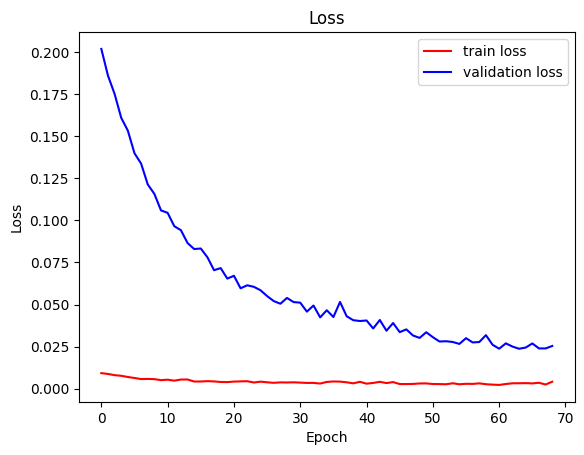

In [42]:
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']
plt.plot(loss_history[10:], color = 'red', label = 'train loss')
plt.plot(val_loss_history[10:], color = 'blue', label = 'validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

585/585 [==============================] - 2s 4ms/step
predicted_price shape: (18710, 2)
real_price shape: (18710, 2)


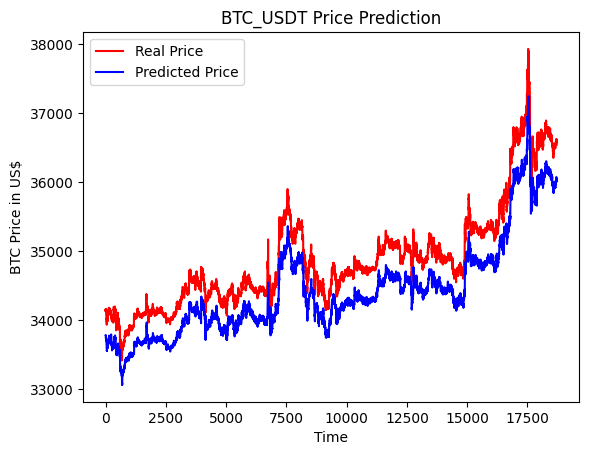

In [43]:
# Predict test data and revert the price to the original scale
predicted_price = regressor.predict(X_test)
predicted_price = sc_target.inverse_transform(predicted_price)
print('predicted_price shape:',predicted_price.shape)
# predicted_price

real_price = sc_target.inverse_transform(y_test)
print('real_price shape:',real_price.shape)
# real_price

plt.plot(real_price[:,0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[:,0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.show()

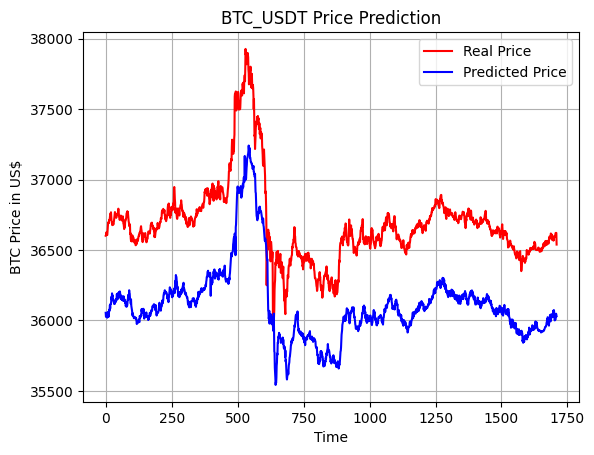

In [44]:
plt.plot(real_price[17000:, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[17000:, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.grid()
plt.show()

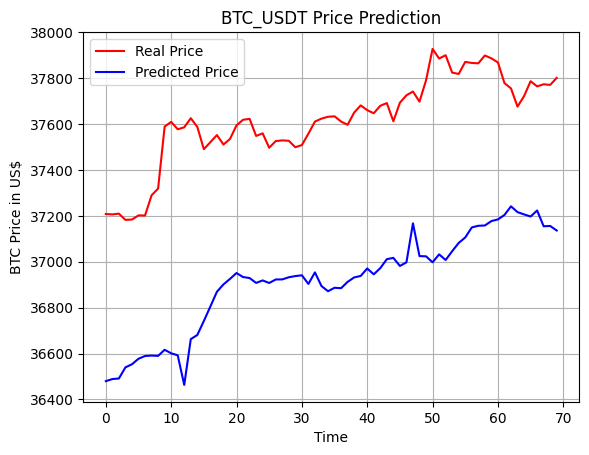

In [45]:
plt.plot(real_price[17480:17550, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[17480:17550, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.grid()
plt.show()

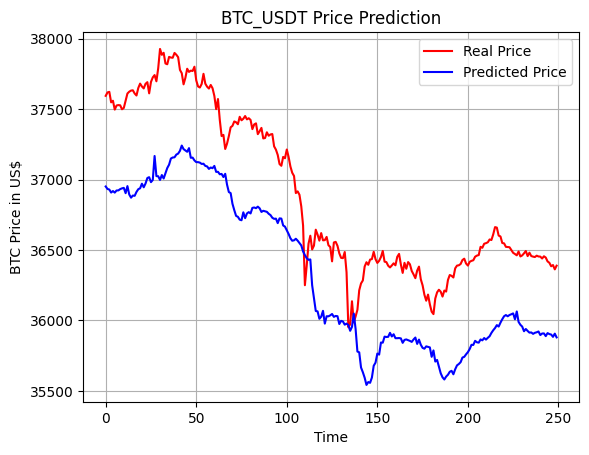

In [46]:
plt.plot(real_price[17500:17750, 0], color = 'red', label = 'Real Price')
plt.plot(predicted_price[17500:17750, 0], color = 'blue', label = 'Predicted Price')
plt.title('BTC_USDT Price Prediction')
plt.xlabel('Time')
plt.ylabel('BTC Price in US$')
plt.legend()
plt.grid()
plt.show()

In [31]:
test_wmse = wmse_loss(real_price, predicted_price)
test_f1 = f1_metric(real_price, predicted_price)

print("test_wmse:",test_wmse)
print("test_f1:",float(test_f1))

test_wmse: 1019077.5256889457
test_f1: 0.601926326751709
